# Lecture 15 - Twitter Analysis

Use this notebook to perform some advanced analytics on Twitter data for your projects. 

Below is the overview of this notebook.

<ol type = 1>
    <li> User Tweets</li>
    <ol type = 1>
      <li> Ratio of Retweets to Followers</li>
      <li> Top Retweeted Tweets</li>
      <li> Keyword vs Retweet Count</li>
      <li> Keyword vs Sentiment</li>
    </ol>
    <li> Keyword Tweets</li>
    <ol type = 1>
      <li> Tweet Rate</li>
      <li> Keyword Tweet Rate</li>
      <li> Interaction Network and Centralities</li>
      <li> Similarity Network and Communities</li>
      <li> Wordcloud Communities</li>
    </ol>
</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture15_TwitterAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

## Install Requirements 


In [ ]:
!pip install -r requirements.txt --quiet


## Import Packages



In [27]:
from datetime import datetime, timedelta
import numpy as np
import sqlite3, sys, os
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import codecs  #this let's us display tweets properly (emojis, etc.)
import regex as re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

#helper code
from scripts.api import *
from scripts.create_graph import *
from scripts.communities import spectral_communities
from scripts.communities import umap_layout,network_thinner
import scripts.TextAnalysis as ta


pd.set_option("display.max_colwidth", None)
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["figure.figsize"] = (10, 6)


# User Tweets

This section will show some analysis you can do on a set of tweets obtained from the timelines of users.  We will use a set of tweets for which we already calculated the sentiment using a transformer (the tweets and sentiment are in a CSV file).

## Load User Tweets

In [2]:
df = pd.read_csv("data/lec_08_tweets_sentiment.csv")
df = df[df.created_at!='es']  #remove one weird tweet in this particular dataset
df['text'] = df['text'].astype(str)  #some tweets are numbers and not strings
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.sample(n=2)

dataframe has 8627 tweets


,Unnamed: 0,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,sentiment
3263,3263,2020-07-13T18:33:53.000Z,BarackObama,Get registered and find out how you can vote by mail at https://t.co/JQJjdF7JxM.,en,6872.0,1062.0,22670.0,335.0,1.282745e+18,813286,1.282745e+18,813286.0,None,3.351872
5969,5967,2021-08-08T13:16:37.000Z,AOC,"RT @PrernaJagadeesh: ""You have to build a life beyond your job, and expecting your job to give you all your happiness isn't going to work,…",en,4678.0,0.0,0.0,0.0,1.424359e+18,138203134,1.424359e+18,NaN,None,1.799133


## Add Created At Datetime Column and Sort

In [3]:
format = "%Y-%m-%d %H:%M:%S"

df['created_at_datetime'] = pd.to_datetime(df['created_at'],format=format).dt.tz_localize(None)
df.sort_values(by = 'created_at_datetime', inplace = True, ascending = True)


## Clean Text

In [4]:
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0

## Load User Profiles

We also collected the profiles for these users and stored them in a database in the `"users"` table.

In [5]:
fname_db = "data/lecture_04"  #database filenmae
df_profile = DB.fetch(table_name="users", path=fname_db)
df_profile.rename(columns = {'username':'screen_name'}, inplace = True)
df_profile.head()

,created_at,name,screen_name,description,id,location,followers_count,following_count,listed_count,tweet_count
0,2009-06-02T20:12:29.000Z,Elon Musk,elonmusk,,44196397,None,72066929,107,85727,16708
1,2013-12-08T08:16:34.000Z,Dogecoin,dogecoin,"Dogecoin is an open source peer-to-peer cryptocurrency, favored by shibas worldwide. Elon Musk thinks we're pretty cool. [RTs are not endorsements]",2235729541,the moon,2961889,12,5556,882
2,2010-07-22T23:00:05.000Z,ye,kanyewest,,169686021,None,30612283,209,43413,1911
3,2009-03-19T19:21:56.000Z,Kim Kardashian West,KimKardashian,@KKWFRAGRANCE @SKIMS,25365536,,71044829,124,72664,35169
4,2011-11-10T20:13:01.000Z,Michelle Obama,MichelleObama,"Girl from the South Side and former First Lady. Wife, mother, dog lover. Always hugger-in-chief. #IAmBecoming",409486555,"Washington, DC",21361348,16,27577,1861


## Only keep tweets for users with profiles


In [12]:
sn = df_profile.screen_name.unique()
df = df[df.screen_name.isin(sn)]

print(sn)

['elonmusk' 'dogecoin' 'kanyewest' 'KimKardashian' 'MichelleObama'
 'BarackObama' 'JBALVIN' 'sanbenito' 'AOC' 'KingJames' 'RashidaTlaib']


## User Tweet Rate

In [ ]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name].copy()
  df_u['tweet_indicator'] = np.ones(len(df_u))
  df_u['rate_1D'] = df_u.rolling('1D',on = 'created_at_datetime')['tweet_indicator'].sum()
  fig = plt.figure(figsize = (12,4))
  sns.lineplot(data = df_u, x = 'created_at_datetime',
               y = 'rate_1D',
              label = 'window = 1 day',
               linewidth = 1,
               color = 'blue',
              marker=None)

  plt.grid()
  plt.xlabel("Time", fontsize = 14)

  plt.ylabel("Rate [tweets/day]", fontsize = 14)
  #plt.ylim([0,30])
  plt.title(f"{screen_name}",fontsize = 20)

  plt.legend()
  plt.show()

## Retweets vs Time

In [ ]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name].copy()
  df_u['tweet_indicator'] = np.ones(len(df_u))
  df_u['retweet_count_1D'] = df_u.rolling('1D',on = 'created_at_datetime')['retweet_count'].mean()
  fig = plt.figure(figsize = (12,4))
  sns.lineplot(data = df_u, x = 'created_at_datetime',
               y = 'retweet_count_1D',
              label = 'window = 1 day',
               linewidth = 1,
               color = 'red',
              marker = 'o')


  plt.grid()
  plt.xlabel("Time", fontsize = 14)

  plt.ylabel("Retweet Count", fontsize = 14)
  #plt.ylim([0,30])
  plt.title(f"{screen_name}",fontsize = 20)

  plt.legend()
  plt.show()

## Ratio of Retweets to Followers

The ratio of mean retweet count to followers count tells you what fraction of a user's followers retweet their content.  This can be a measure of how engaged a user's followers are.

In [ ]:
df_r = df.groupby(by = 'screen_name')[['retweet_count']].mean()
df_r.reset_index(inplace = True)
df_profile = pd.merge(df_profile, df_r, on="screen_name")
df_profile['retweet_followers_ratio'] = df_profile.retweet_count/df_profile.followers_count
df_profile.sort_values(by = 'retweet_followers_ratio', ascending = False, inplace = True)
df_profile.head(n=3)

## Bar Plot of Retweet to Followers Ratio

In [ ]:
ax = sns.barplot(data = df_profile,
                x = 'screen_name', 
                 y = 'retweet_followers_ratio',
                 color = 'darkorange')
plt.ylabel("Retweet to Followers Ratio")
plt.xlabel("Screen Name")
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 90)
plt.grid()
plt.show()


## Top Retweeted Tweets

We will look at the most retweeted tweets for each users.  We have to filter out any retweets as these are not produced by the user.  We do this by removing any tweet that contains `"RT @"`.

In [ ]:
ndisplay = 3  #number of tweets to display

for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name].copy()
  df_u = df_u[df_u.text.str.contains("RT @", case=False)==False] #remove any retweets
  df_u.sort_values(by = 'retweet_count', ascending = False, inplace = True)
  print("\n")
  display(df_u[['screen_name','retweet_count','text']].head(n=ndisplay))

## Keyword vs Retweet Count Per User

We might be interested in which words get more retweets when included in a tweet.  We make a list `keywords` of words we are interested in.  Then we go through each user and plot the mean retweet count of their tweets which contain the word.

In [ ]:
keywords = ['love','trump','hate','biden']

for keyword in keywords:
    ind =  df.text.str.contains(keyword, case=False)
    df.loc[ind, 'keyword'] = keyword 
    


In [ ]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name].copy()
  ax = sns.barplot(data = df_u, 
                   x = 'keyword', 
                   y = 'retweet_count', 
                   color = 'darkorange')
  plt.ylabel("Retweet Count")
  plt.xlabel("Keyword")
  plt.title(screen_name,fontsize = 20)
  plt.grid()
  plt.show()

## Keyword vs Sentiment Per User

We can also look at the mean sentiment of tweets containing keywords.

In [ ]:
keywords = ['love','trump','hate','biden']

In [ ]:
df.columns

In [ ]:
for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name]
  ax = sns.barplot(data = df_u, 
                   x = 'keyword', 
                   y = 'sentiment',
                   color = 'purple')
  plt.ylabel("Sentiment")
  plt.xlabel("Keyword")
  plt.title(screen_name,fontsize = 20)
  plt.grid()
  plt.show()

## Top Words and Word Clouds

This code will create a world cloud and a histogram of the most common words used in a set of tweets. We will do this for each user.  

First, we clean the text.  Then we create the wordcloud for each user.  
We obtain the word frequencies from the dictionary `wordcloud.words_` attached to the `wordcloud` object.  We make a dataframe `df_words` with the columns `"word"` and `"frequency"`.  We plot the word cloud and word frequencies for each user.  We plot the top `words_max` words for each user.

In [ ]:
stopwords = set(STOPWORDS)  #set the stopwords
words_max = 10 #maximum number of words to plot in word frequency plot


for screen_name in df.screen_name.unique():
  df_u = df[df.screen_name==screen_name]
  text=' '.join(df_u.text_clean.tolist()).lower()

  #generate word cloud
  wordcloud = WordCloud(stopwords=stopwords,
                        max_font_size=150, 
                        max_words=100, 
                        background_color="black",
                        width=1000, 
                        height=600)
  wordcloud.generate(text)

  #create dataframe of words and frequencies
  df_words = pd.DataFrame({'word':wordcloud.words_.keys(), 
                           'frequency':wordcloud.words_.values()})
  df_words = df_words.sort_values(by = 'frequency', 
                                  ascending = False)

  #plot word cloud and word frequencies
  plt.figure(figsize = (16,6))
  plt.subplot(1,2,1)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(f"{screen_name}", fontsize = 20)
  plt.axis("off")

  plt.subplot(1,2,2)
  ax= sns.barplot(data = df_words[0:words_max], 
                  x = 'word', 
                  y = 'frequency', 
                  color = 'orange')
  ax.set_xticklabels(ax.get_xticklabels(),
                     rotation = 90)
  plt.grid()
  plt.show()

# Keyword Tweets

This section will show some analysis you can do on a set of tweets obtained by keyword search.

## Load Keyword Tweets and Clean Text

In [7]:
fname_db = "data/lecture_02"  #database filenmae
df = DB.fetch(table_name='keyword_tweets', path=fname_db)
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0

print(f"{len(df)} keyword tweets")
df.sample(n=2)

4805 keyword tweets


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo,entities,text_clean
3861,2022-01-02T02:36:26.000Z,Robert_Vandal_,@NotoriousPlank I made a remix of Mega Mutant that \n@TaylorGerring\n\n owns.\nGRIM RE APE R\n6.66$eth price\n1/1\nhttps://t.co/8ogTwzhjwB\n#nftcollector #nft #nftart #NFTCommunity #nftshill #nftcollection #MutantApeYachtClub #MutantFam #MegaMutant #MAYC #BAYC #BoredApe #BoredApeYachtClub #opensea https://t.co/GrJIWHlwax,en,1,0,1,0,1477468800215699459,1439328451161296899,1477451145023008770,1476387295318220805,nan,"{'mentions': [{'start': 0, 'end': 15, 'username': 'NotoriousPlank', 'id': '1476387295318220805'}, {'start': 52, 'end': 66, 'username': 'TaylorGerring', 'id': '14295211'}], 'urls': [{'start': 108, 'end': 131, 'url': 'https://t.co/8ogTwzhjwB', 'expanded_url': 'https://opensea.io/assets/matic/0x2953399124f0cbb46d2cbacd8a89cf0599974963/21900439376692531289016312516961176095977909913253618231007666705584399319041/', 'display_url': 'opensea.io/assets/matic/0…'}, {'start': 291, 'end': 314, 'url': 'https://t.co/GrJIWHlwax', 'expanded_url': 'https://twitter.com/Robert_Vandal_/status/1477468800215699459/photo/1', 'display_url': 'pic.twitter.com/GrJIWHlwax'}], 'hashtags': [{'start': 132, 'end': 145, 'tag': 'nftcollector'}, {'start': 146, 'end': 150, 'tag': 'nft'}, {'start': 151, 'end': 158, 'tag': 'nftart'}, {'start': 159, 'end': 172, 'tag': 'NFTCommunity'}, {'start': 173, 'end': 182, 'tag': 'nftshill'}, {'start': 183, 'end': 197, 'tag': 'nftcollection'}, {'start': 198, 'end': 217, 'tag': 'MutantApeYachtClub'}, {'start': 218, 'end': 228, 'tag': 'MutantFam'}, {'start': 229, 'end': 240, 'tag': 'MegaMutant'}, {'start': 241, 'end': 246, 'tag': 'MAYC'}, {'start': 247, 'end': 252, 'tag': 'BAYC'}, {'start': 253, 'end': 262, 'tag': 'BoredApe'}, {'start': 263, 'end': 281, 'tag': 'BoredApeYachtClub'}, {'start': 282, 'end': 290, 'tag': 'opensea'}]}",notoriousplank i made a remix of mega mutant that taylorgerring ownsgrim re ape r666eth price11nftcollector nft nftart nftcommunity nftshill nftcollection mutantapeyachtclub mutantfam megamutant mayc bayc boredape boredapeyachtclub opensea
2724,2022-01-03T18:39:47.000Z,pyramidgenius_G,♾Awoken Bored Apes:\nBored Ape: Mind #5078\n🦧💥👁\nLink In Bio\n\n#nftcollectibles #boredape #nfts #polygon #nftcollector #nftartwork #opensea #boredapeyachtclub https://t.co/lXQk7FYtl8,en,0,0,0,0,1478073621700616193,1278179866123403265,1478073621700616193,nan,nan,"{'urls': [{'start': 156, 'end': 179, 'url': 'https://t.co/lXQk7FYtl8', 'expanded_url': 'https://twitter.com/pyramidgenius_G/status/1478073621700616193/photo/1', 'display_url': 'pic.twitter.com/lXQk7FYtl8'}], 'hashtags': [{'start': 59, 'end': 75, 'tag': 'nftcollectibles'}, {'start': 76, 'end': 85, 'tag': 'boredape'}, {'start': 86, 'end': 91, 'tag': 'nfts'}, {'start': 93, 'end': 101, 'tag': 'polygon'}, {'start': 102, 'end': 115, 'tag': 'nftcollector'}, {'start': 116, 'end': 127, 'tag': 'nftartwork'}, {'start': 128, 'end': 136, 'tag': 'opensea'}, {'start': 137, 'end': 155, 'tag': 'boredapeyachtclub'}]}",awoken bored apesbored ape mind 5078link in bionftcollectibles boredape nfts polygon nftcollector nftartwork opensea boredapeyachtclub


## Word Cloud of Keyword Tweets

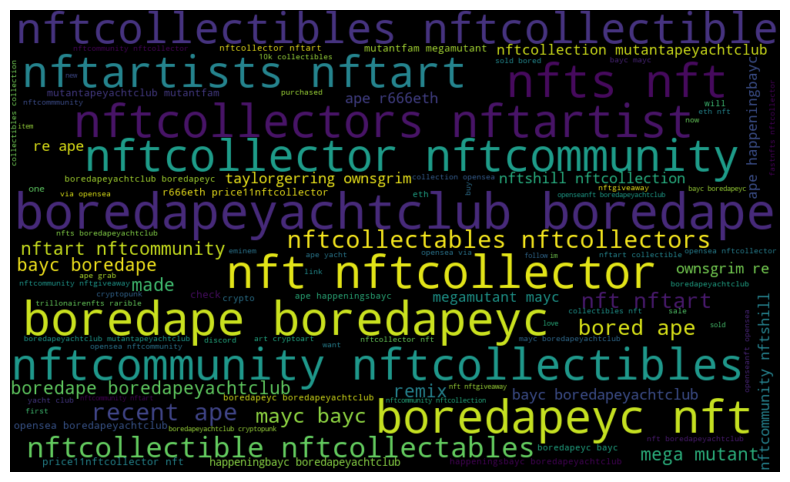

In [9]:
stopwords = set(STOPWORDS)


text=' '.join(df.text_clean.tolist()).lower()
#generate word cloud
wordcloud = WordCloud(stopwords=stopwords,
                    max_font_size=150, 
                    max_words=100, 
                    background_color="black",
                    width=1000, 
                    height=600)
wordcloud.generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Add Created At Datetime Column and Sort

In [10]:
format = "%Y-%m-%d %H:%M:%S"
df['created_at_datetime'] = pd.to_datetime(df['created_at'],format=format).dt.tz_localize(None)
df.sort_values(by = 'created_at_datetime', 
               inplace = True, 
               ascending = True)

#define initial and final time variables (for plot axis limits)
ti = df.created_at_datetime.head(n=1).values[0]
tf = df.created_at_datetime.tail(n=1).values[0]

print(f"Head: {ti}")
print(f"Tail: {tf}")

Head: 2022-01-01T00:00:18.000000000
Tail: 2022-01-07T23:58:24.000000000


## Tweet Rate

In [ ]:
df['tweet_indicator'] = np.ones(len(df))
df['rate_1D'] = df.rolling('1D',on = 'created_at_datetime')['tweet_indicator'].sum()


In [ ]:
fig = plt.figure(figsize = (12,4))
sns.lineplot(data = df, 
             x = 'created_at_datetime',
             y = 'rate_1D',
             label = 'window = 1 day',
             linewidth = .5,
             color = 'blue')


plt.grid()
plt.xlabel("Time")
plt.ylabel("Rate [tweets/day]")
plt.xlim(ti,tf)
#plt.ylim([0,30])
plt.title(f"{len(df)} Tweets",fontsize = 20)
plt.legend()
plt.show()

## Keyword Frequency

In [ ]:
keywords = ['eth','doge','btc','ada','bnb']

for keyword in keywords:
    ind =  df.text.str.contains(keyword, case=False)
    df.loc[ind, 'keyword'] = keyword 
ax = sns.countplot(data = df, 
                 x = 'keyword')
plt.grid()
plt.xlabel("Keyword")
plt.ylabel("Frequency")
ax.set_xticklabels(ax.get_xticklabels(),
                     rotation = 90)
plt.show()

## Keyword Tweet Rate

In [ ]:
#single plots for all keywords

keywords = ['eth','doge','btc','ada','bnb']
colors = ['red','blue','orange','green','cyan']
fig = plt.figure(figsize = (12,4))

for color,keyword in zip(colors,keywords):
  df_plot = df[df.text.str.contains(keyword, case=False)].copy()
  df_plot['tweet_indicator'] = np.ones(len(df_plot))
  df_plot[f'rate_1D_{keyword}'] = df_plot.rolling('1D',on = 'created_at_datetime')['tweet_indicator'].sum()

  sns.lineplot(data = df_plot, 
               x = 'created_at_datetime',
               y = f'rate_1D_{keyword}',
               label = keyword,linewidth = 1,
               color = color)


plt.grid()
plt.xlabel("Time")
plt.ylabel("Rate [tweets/day]")
plt.xlim(ti,tf)
#plt.ylim([0,30])

plt.legend()
plt.show()

### Seperate Plots for Each Keyword


In [ ]:

keywords = ['eth','doge','btc','ada','bnb']

for keyword in keywords:
    df_plot = df[df.text.str.contains(keyword, case=False)].copy()
    print(f"{len(df_plot)} tweets contain {keyword}")
    df_plot['tweet_indicator'] = np.ones(len(df_plot))
    df_plot[f'rate_1D_{keyword}'] = df_plot.rolling('1D',on = 'created_at_datetime')['tweet_indicator'].sum()

    fig = plt.figure(figsize = (12,4))
    sns.lineplot(data = df_plot, 
                 x = 'created_at_datetime',
                 y = f'rate_1D_{keyword}',
                 label = 'window = 1 day',
                 linewidth = 1,
                 color = 'blue')


    plt.grid()
    plt.xlabel("Time")
    plt.ylabel("Rate [tweets/day]")
    plt.xlim(ti,tf)
    #plt.ylim([0,30])
    plt.title(f"Tweets Containing {keyword}",fontsize = 20)

    plt.legend()
    plt.show()

## Find Tweets Containing at Least One Keyword

You may want to find tweets that contain at least one word from a list of keywords.  Define the keyword list `keywords`.  Then the code below will return a dataframe `df_keywords` that only has tweets with the keywords.

In [ ]:
keywords = ['eth','btc']
df_keywords = df[df.text.str.contains('|'.join(keywords), case = False)] 

print(f"df has {len(df)} tweets")
print(f"df_keywords has {len(df_keywords)} tweets that contain at least one of {keywords}")


# Interaction Network

## Build Interaction Network From Keyword Tweets

We can build an interaction network from the tweets in the `keyword_tweets` table using the function `interaction_network_from_tweets`.
The interaction network includes retweets, replies, and regular mentions of other users.  Our edge convention points to the person tweeting from the person being mentioned in the tweet. 

The user inputs are as follows:

1. `fname_db` = database filename where you stored the keyword tweets.  Do not add the `".db"` suffix.

2. `fname_interaction_network` = name of the file where you will save the interaction network.  Make sure it ends with `".pickle"`.

In [12]:
fname_db = "data/lecture_02"  #database filenmae
fname_interaction_network = 'data/lecture_02_interaction_network.pickle'

df = DB.fetch(table_name='keyword_tweets', path=fname_db)
df['text_clean'] = df.text.apply(ta.clean_tweet)  #clean the tweets
df = df[df.text_clean.str.len() >0]  #remove cleaned tweets of lenght 0


G = interaction_network_from_tweets(df)


G has 2806 nodes and 3322 edges


In [ ]:
#Save interaction network
pickle.dump(G, open(fname_interaction_network, 'wb'))


## Draw Interaction Network

In [ ]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 3
node_color = 'red'



In [ ]:
G = pickle.load(open(fname_interaction_network, 'rb'))

%time pos_umap = umap_layout(G)  #~ 30 sec

fig = plt.figure(figsize=(8,8))
nx.draw(G, pos_umap, 
        node_color = node_color, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
        with_labels=False,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Interaction Network",
          color = 'white',
          fontsize = 14)
plt.show()
    


## Centrality calculation

We can look at the nodes with the highest network centralities.

In [102]:
%%time 
#~30 sec

Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())  #undirected interation network works better for betweenness centrality

dictionary_list = []
for author_id in Din.keys():
    screen_name = G.nodes[author_id]['username']
    row = {'author_id':author_id,
           'screen_name':screen_name,
          'out_degree_centrality':Dout[author_id],
          'closeness_centrality':CC[author_id],
          'betweenness_centrality':BC[author_id],
          'eigenvector_centrality':EC[author_id],
          'in_degree_centrality':Din[author_id]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)


Wall time: 28.9 s


## Look at Top Centrality Users

In [103]:
centrality = "closeness_centrality"
nmax = 10  #number of top screen names to display
df_centrality.sort_values(by = [centrality],ascending = False)[['screen_name',centrality]].head(n=nmax)


,screen_name,closeness_centrality
3,BoredApeYC,0.137655
8,opensea,0.054833
57,rarible,0.041711
1021,TrillonaireNFTs,0.037790
141,Eminem,0.018424
940,WhaleCoinTalk,0.009982
332,BACryptoPaint,0.008926
390,garyvee,0.007254
364,BoredApeBC,0.006079
275,apocalypticapes,0.006061


## Plot Centralities

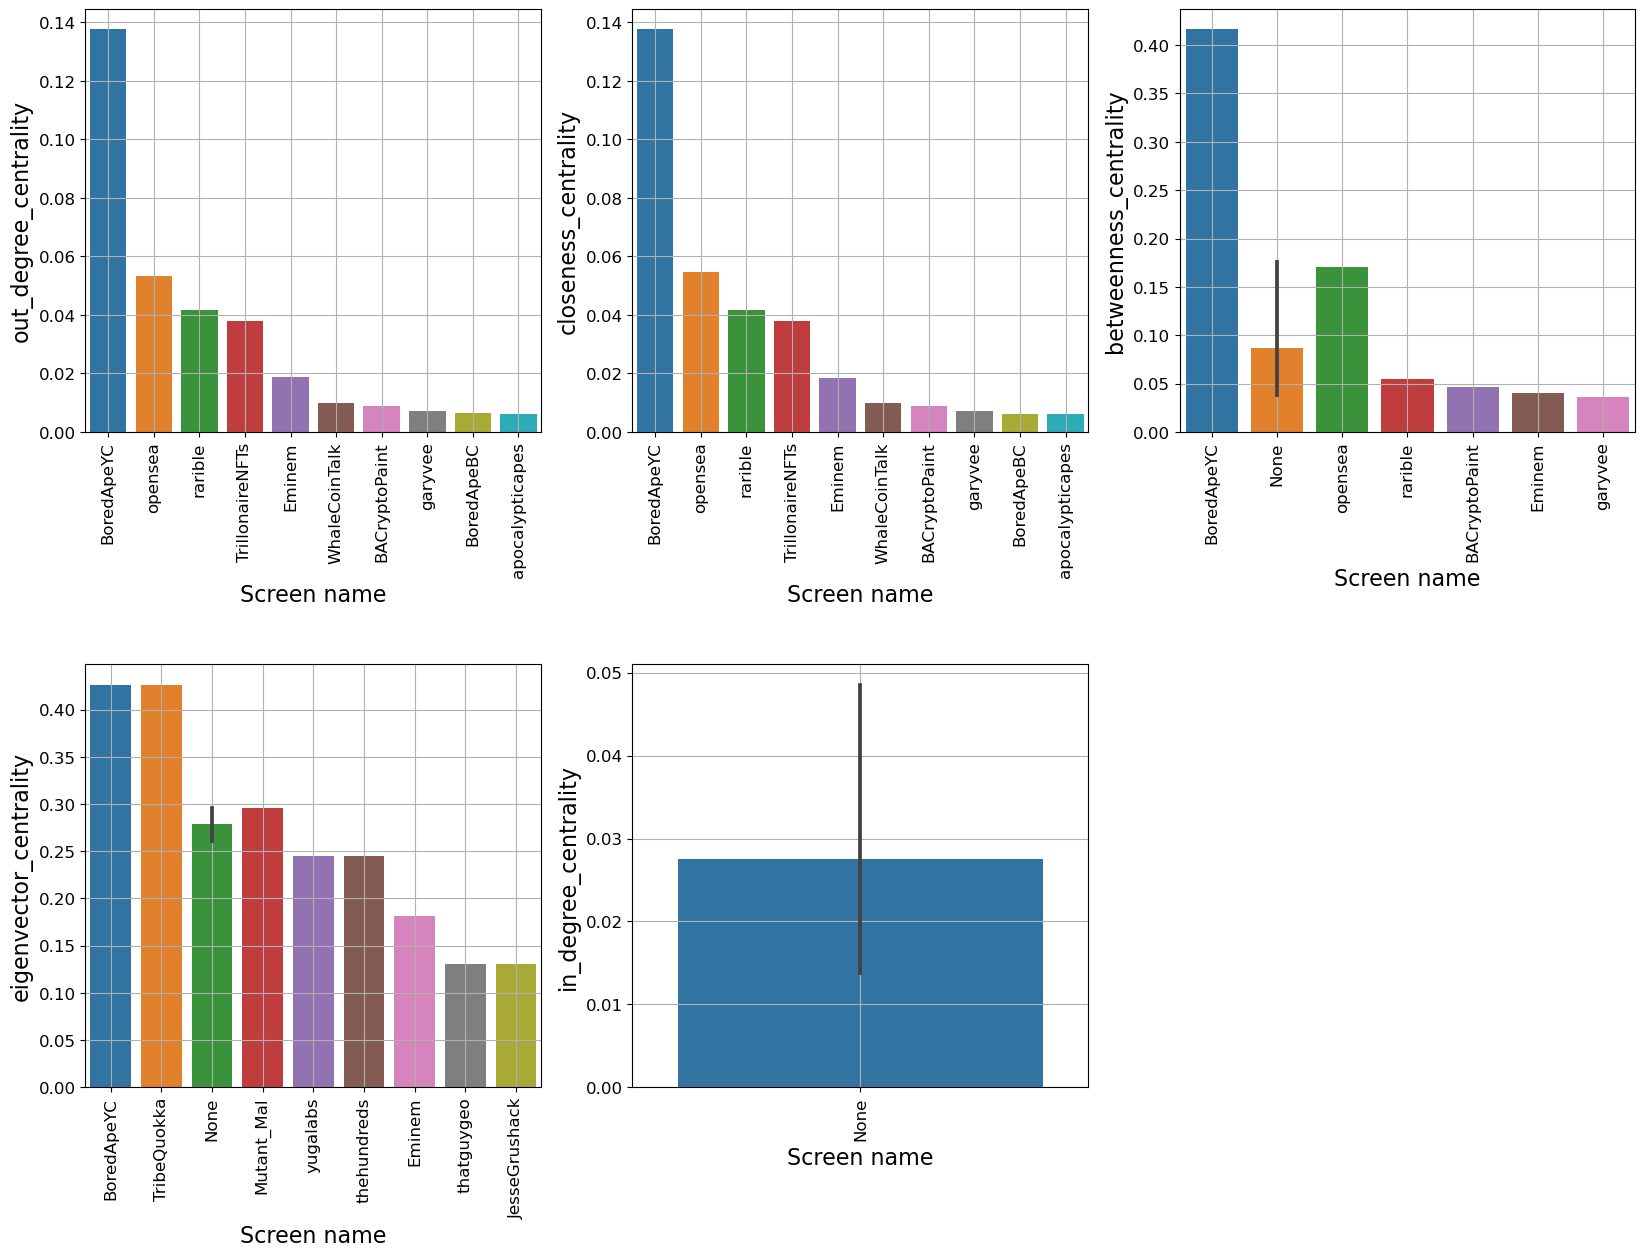

In [104]:
Centrality_names = df_centrality.columns.tolist()[2:]
nmax = 10  #number of top screen names to plot


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):  
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False)  #sort dataframe by centrality value
    plt.subplot(2,3,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    
    ax = sns.barplot(data = df_plot[0:nmax], 
                     x='screen_name', 
                     y=centrality_name)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.ylabel(f"{centrality_name}")
    plt.xlabel('Screen name')
    plt.grid()

plt.subplots_adjust(left=None, 
                    bottom=None, 
                    right=None, 
                    top=None, 
                    wspace=None, 
                    hspace=0.55)

plt.show()

# Similarity Network

## Build Similarity Network

We can build a similarity network from the interaction network.  In this network there is an edge between a pair of nodes of their similarity exceeds a minimum threshold.  For similarity, we use a measure called the Jaccard Coefficient (https://en.wikipedia.org/wiki/Jaccard_index).  The similarity network is useful for finding communities.

The user inputs are as follows:

1. `fname_interaction_network` = name of the file where you saved the interaction network.  Make sure it ends with `".pickle"`.

2. `fname_similarity_network` = name of the file where you will save the similarity network.  Make sure it ends with `".pickle"`.

3. `ne_max` = the maximum number of edges in the similarity network

4. `jmin` = minimum value of jaccard coefficient of an edge in order to keep it in the similarity network

In [13]:
fname_interaction_network = 'data/lecture_02_interaction_network.pickle'
fname_similarity_network = 'data/lecture_02_similarity_network.pickle'


In [14]:
%%time 
#~ 60 sec


ne_max = 1e7  #max number of edges in network
jmin = 0.5  #minimum value of jaccard coefficient to keep in network


G = pickle.load(open(fname_interaction_network, 'rb'))

Gsim = retweet_similarity_network(G, jmin, ne_max)

2806 nodes in retweet network
3935415  node pairs to check Jaccard index
Create similarity graph using Jacard coefficient > 0.000
1000000 35070  positive weights
2000000 66662  positive weights
3000000 101019  positive weights
Gsim has 2515 nodes, 164909 edges
Wall time: 56.8 s


In [15]:
#save similarity network
pickle.dump(Gsim, open(fname_similarity_network, 'wb'))


## Find Modularity Communities Using Similarity Network

We can find the modularity communities in the similarity network and plot their sizes.

In [16]:
Gsim = pickle.load(open(fname_similarity_network, 'rb'))


In [17]:
%%time
Comm = nx_comm.greedy_modularity_communities(Gsim.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")

110 modularity communities


## Find Spectral Communities Using Similarity Network

We can find the spectral communities in the similarity network and plot their sizes.  Spectral is nicer because we can choose how many communities we want.

In [18]:
%%time
k = 8
df_spec = spectral_communities(Gsim,k)

ncomm_spec = len(df_spec.community.unique())
print(f"{ncomm_spec} spectral communities")

C:\Users\trz2\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\trz2\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


8 spectral communities


## Plot Community Sizes

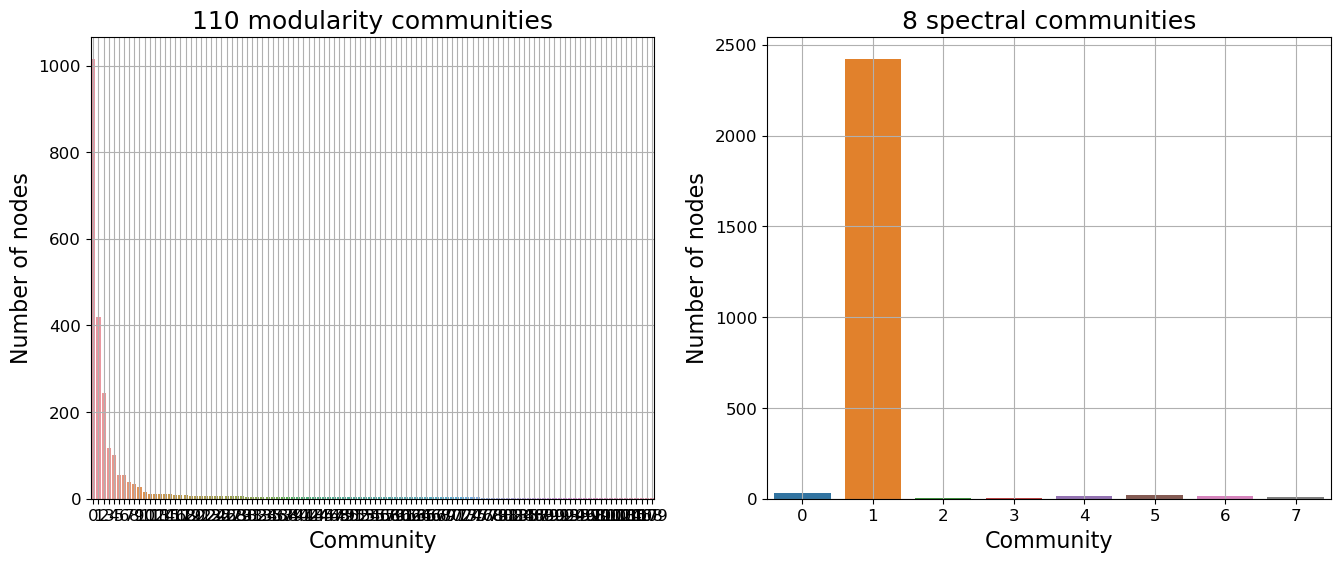

In [19]:
fig = plt.figure(figsize = (16,6))

#plot modularity community sizes

plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, 
                   x="community")
plt.xlabel("Community")
plt.ylabel("Number of nodes")
plt.title(f"{ncomm_mod} modularity communities", fontsize = 18)
plt.grid()


#plot spectral community sizes
plt.subplot(1,2,2)
ax = sns.countplot(data=df_spec, 
                   x="community")
plt.xlabel("Community")
plt.ylabel("Number of nodes")
plt.title(f"{ncomm_spec} spectral communities", fontsize = 18)
plt.grid()
plt.show()

## Draw Similarity Network with Community Colors

In [20]:
edge_color = 'purple'
background_color = 'black'
edge_width = .1
node_size = 10

In [21]:
#Assign community colors to nodes
Colors = [np.random.uniform(0,1,3) for _ in range(10000)]

node_color_spec = [Colors[df_spec.community[df_spec.screen_name==node].values[0]] for node in df_spec.screen_name]
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in df_mod.screen_name]


In [22]:
#calculate layout for similarity network using UMAP
%time pos_umap_sim = umap_layout(Gsim)

Wall time: 23.3 s


## Thin Network for Plotting

If we randomly keep only `final_frac` of the edges, it will make drawing the network faster and the drawing will be more informative.

In [ ]:
final_frac = 0.1
Gthin = network_thinner(Gsim,final_frac)


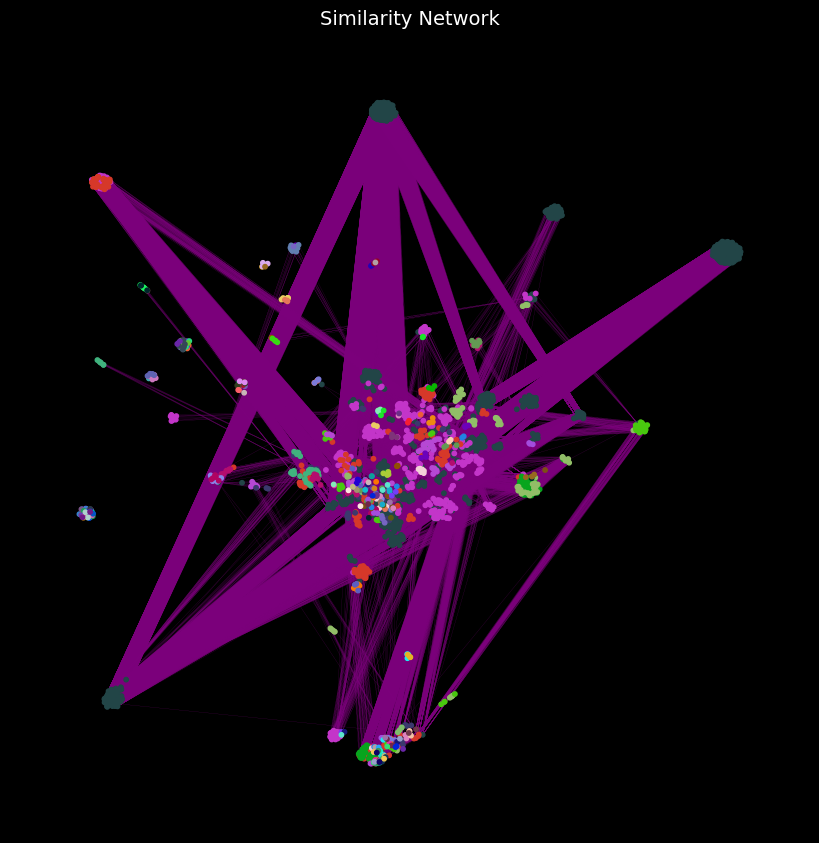

In [23]:
fig = plt.figure(figsize=(8,8))
nx.draw(Gthin, pos_umap_sim, 
        node_color = node_color_mod, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
        with_labels=False,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Similarity Network",color = 'white',fontsize = 14)
plt.show()
    


## Wordcloud Tweets in Each Community

In [24]:
stopwords = set(STOPWORDS)
stopwords.add("boredapeyachtclub")
stopwords.add("boredapeyc")
stopwords.add("nft")
stopwords.add("nfts")

Community 0: 1016 users, 1752 tweets


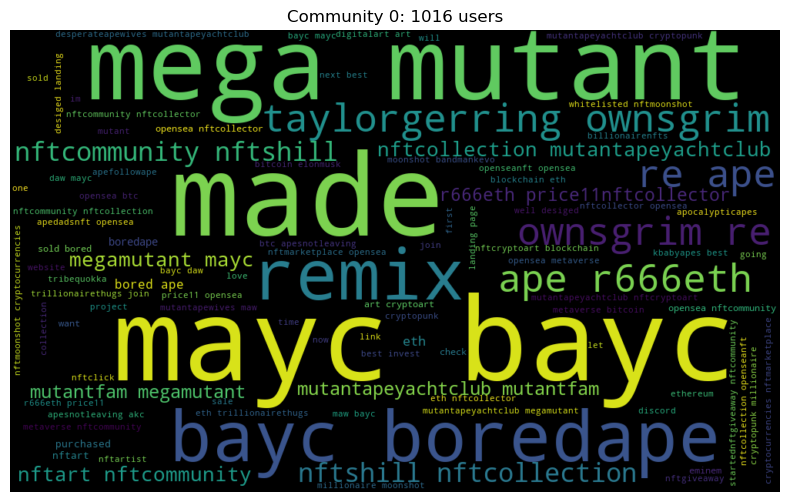

Community 2: 244 users, 763 tweets


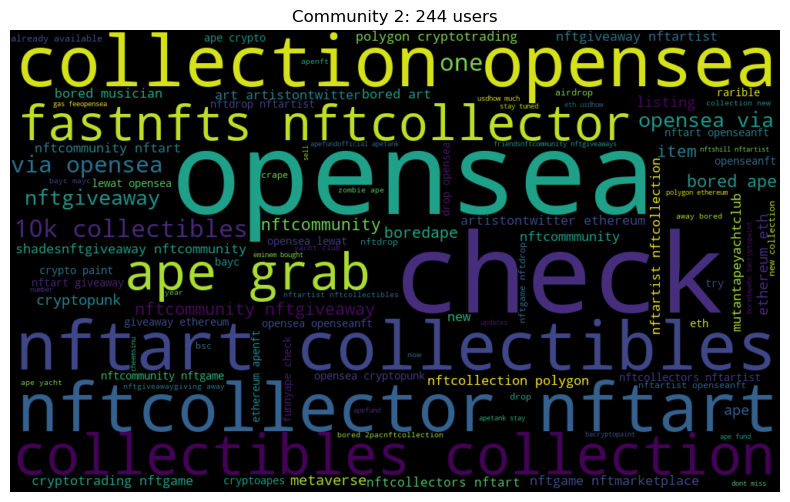

Community 3: 116 users, 139 tweets


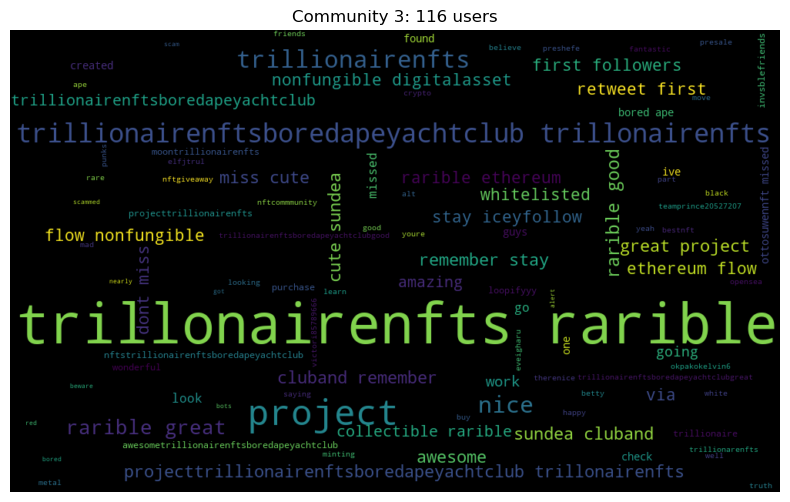

In [26]:
for community in df_mod.community.unique():
    V = df_mod.screen_name[df_mod.community==community].tolist()
    df1 = df[df.author_id.isin(V)]
    

    if len(df1)>100: #at least 100 tweets
        title = f"Community {community}: {len(V)} users, {len(df1)} tweets"
        print(title)
        text=' '.join(df1.text_clean.tolist()).lower()

        wordcloud = WordCloud(stopwords=stopwords,
                              max_font_size=150, 
                              max_words=100, 
                              background_color="black",
                              width=1000, 
                              height=600)
        wordcloud.generate(text)

        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(title)
        plt.axis("off")
        plt.show()